<a href="https://colab.research.google.com/github/ACOOLS/IA/blob/master/Vision_Transformer_Tutorial_2023_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer

Adapted from Hiroto Honda  (https://hirotomusiker.github.io/)  

Paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929

Le Vision Transformer utilise le "Transformer Encoder" proposé dans [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

Implementation References:

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)




# Préparation de l'environnement

In [ ]:
%%capture
!pip install timm==0.4.9

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from timm import create_model

# Préparation du modèle et des images

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)
img_size = 224 #taille des images d'ImageNet

device =  cpu


In [ ]:
# Define transforms for test
IMG_SIZE = (img_size, img_size)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://pytorch.org/tutorials/_images/cat_224x224.jpg -O chat.png

img = PIL.Image.open('chat.png')

img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference

In [ ]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
Egyptian_cat



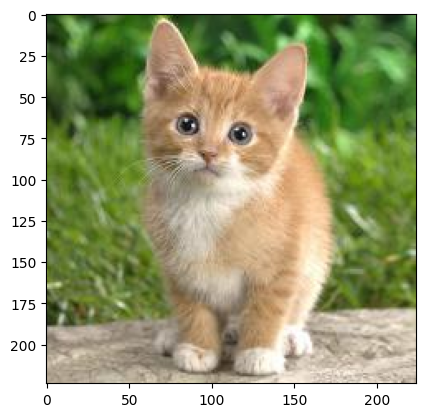

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Preprocessing avant le transformeur


# 1. Décomposition en patchs

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img.size)

print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)
n_patch_per_side = 16 #pour Vit base
patch_size = img_size//n_patch_per_side

Image tensor:  (224, 224)
Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


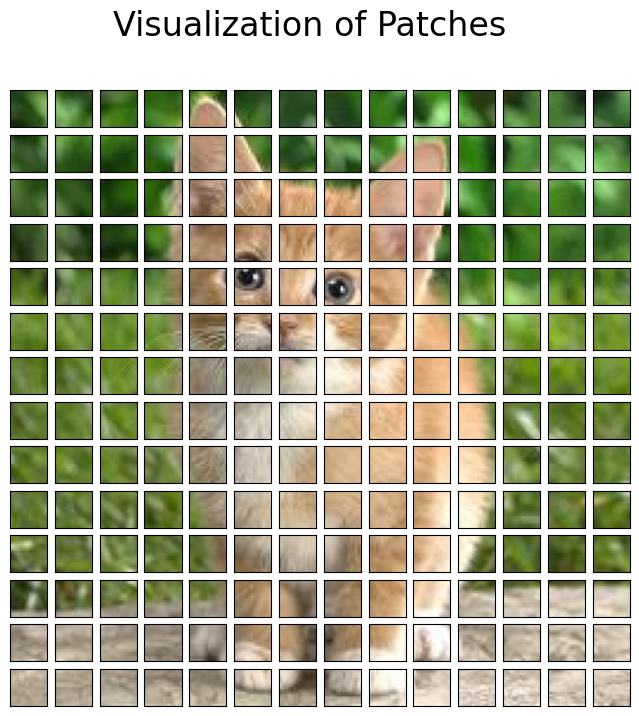

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=15)

img = np.asarray(img)
for i in range(0, patch_size*patch_size):
    x = i % patch_size
    y = i // patch_size
    patch = img[y*n_patch_per_side:(y+1)*n_patch_per_side, x*n_patch_per_side:(x+1)*n_patch_per_side]

    ax = fig.add_subplot(patch_size, patch_size, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


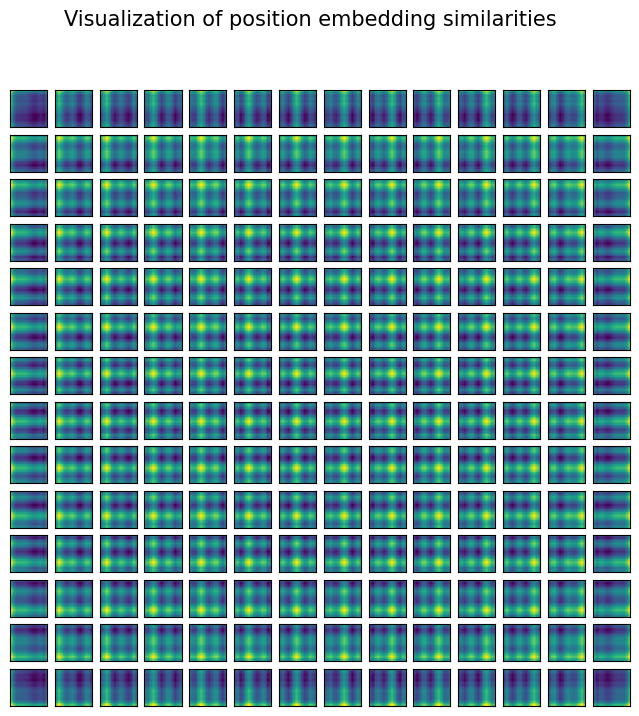

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=15)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder




In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

NameError: name 'transformer_input' is not defined

## Méchanisme d'attention


In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


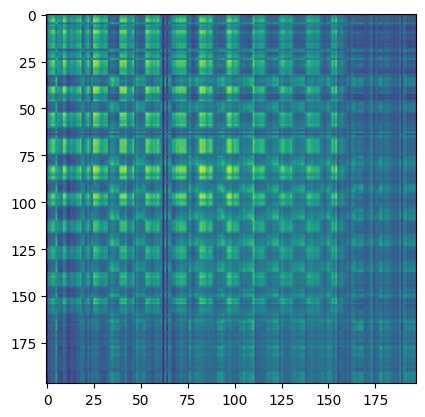

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

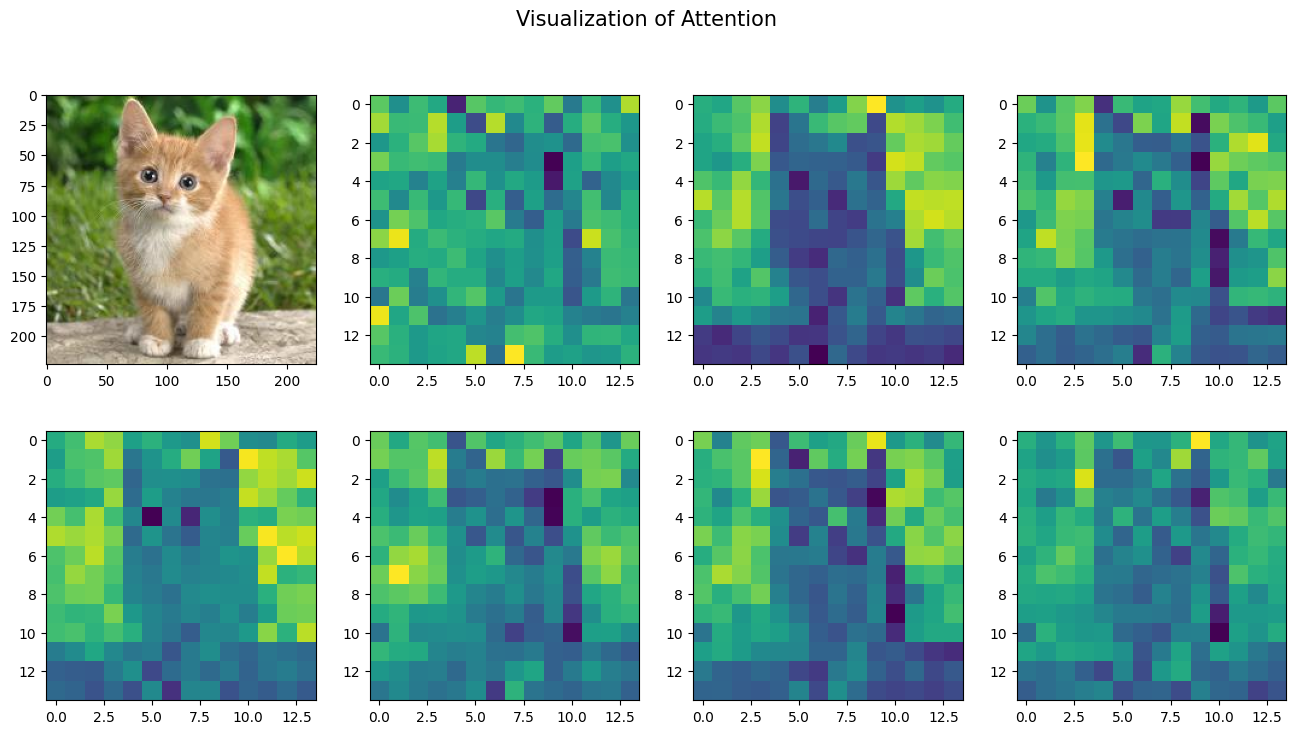

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=15)

img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

NameError: name 'model' is not defined

### **Entrainement d'un ViT**


Préparation datasets

In [ ]:
import os
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
import torch
import matplotlib.pyplot as plt



DATASET_PATH = os.environ.get(".", "data/")

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

batch_size = 4

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)



100%|██████████| 170498071/170498071 [00:15<00:00, 10943531.40it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


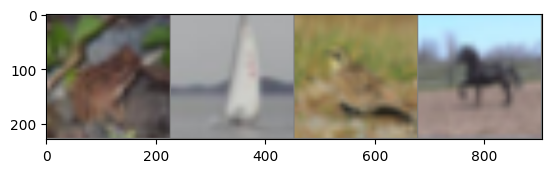

frog  ship  bird  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
from torchvision.models.vision_transformer import vit_b_16

model = vit_b_16(weights='IMAGENET1K_V1')
print(model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 81.6MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
model.heads.head = torch.nn.Linear(in_features=768, out_features=10, bias=True)



In [ ]:

import time
import csv

lr = 0.0001
n_epochs = 5
best_acc = 0


# Loss is CE
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)


# use cosine scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

##### Training

scaler = torch.cuda.amp.GradScaler()

def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # Train with amp
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


    return train_loss/(batch_idx+1)

##### Validation
def validation(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {"model": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "scaler": scaler.state_dict()}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/vit'+'-ckpt.t7')
        best_acc = acc

    os.makedirs("log", exist_ok=True)
    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, val loss: {test_loss:.5f}, acc: {(acc):.5f}'
    print(content)
    with open(f'log/log_vit_patch.txt', 'a') as appender:
        appender.write(content + "\n")
    return test_loss, acc

list_loss = []
list_acc = []

model.cuda()

for epoch in range(0, n_epochs):
    start = time.time()
    trainloss = train(epoch)
    val_loss, acc = validation(epoch)

    scheduler.step(epoch-1) # step cosine scheduling

    list_loss.append(val_loss)
    list_acc.append(acc)


    # Write out csv..
    with open(f'log/log_vit.csv', 'w') as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerow(list_loss)
        writer.writerow(list_acc)
    print(list_loss)


Epoch: 0
Saving..
Mon Jan 15 10:13:10 2024 Epoch 0, lr: 0.0005000, val loss: 2014.04454, acc: 40.02000
[2014.0445385575294]

Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Saving..
Mon Jan 15 10:26:17 2024 Epoch 1, lr: 0.0004523, val loss: 1896.96271, acc: 43.82000
[2014.0445385575294, 1896.9627076387405]

Epoch: 2
Saving..
Mon Jan 15 10:39:25 2024 Epoch 2, lr: 0.0005000, val loss: 1779.35608, acc: 46.70000
[2014.0445385575294, 1896.9627076387405, 1779.3560775220394]

Epoch: 3
Saving..
Mon Jan 15 10:52:31 2024 Epoch 3, lr: 0.0004523, val loss: 1660.06055, acc: 50.14000
[2014.0445385575294, 1896.9627076387405, 1779.3560775220394, 1660.0605455040932]

Epoch: 4
Saving..
Mon Jan 15 11:05:39 2024 Epoch 4, lr: 0.0003273, val loss: 1566.05121, acc: 54.10000
[2014.0445385575294, 1896.9627076387405, 1779.3560775220394, 1660.0605455040932, 1566.0512139499187]


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {round(100*correct/total, 2)} %')